In [57]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [58]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [59]:
participants = pd.read_csv(participants_file, index_col=0)


In [60]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [61]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [62]:
# participants[:] = participants.sample(frac=1).values

In [63]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,0
mv_SYNESTHEX_S_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_M_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_K_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,2,1
mv_SYNESTHEX_Y_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,1,1,1
mv_SYNESTHEX_G_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_D_Session1_S2_T1w,1,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

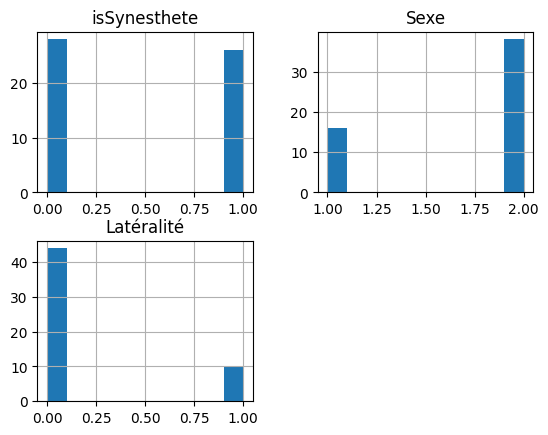

In [64]:
participants.hist()

In [65]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [66]:
model_paths = get_model_paths(path_champollion)

In [67]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [68]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [69]:
def compute(model_path, random_state):
    global embeddings
    global participants
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label, "folds"]].merge(embeddings, left_index=True, right_index=True)
    
    # Set up possible values of parameters to optimize over
    p_grid = {"C": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}
          
    # Classifies
    X = merged.drop([label, "folds"], axis=1)
    Y = merged[label]
    groups = merged["folds"]
    df2 = X.copy()
    # pca = PCA(n_components=20)
    # df2 = pd.DataFrame(pca.fit_transform(X))
    # df2.index = X.index
    scaler = StandardScaler()
    df2[df2.columns] = scaler.fit_transform(df2)
    model = LogisticRegression(max_iter=max_iter, class_weight='balanced', C=0.000001, random_state=random_state)
    logo = LeaveOneGroupOut()
    cv = logo.split(df2, Y, groups)
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=3)
    res = cross_val_score(model, df2, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [70]:
def iterative_split_through_sorting_shuffle(df, n_splits, stratify_columns, random_state):
    """Custom iterative train test split which
    maintains balanced representation.
    """
    # Dataframe random row shuffle + sorting according to stratify_columns
    sorted = df.sample(frac=1, random_state=random_state).sort_values(stratify_columns)
    # for each fold, we take one row every n_splits rows
    folds = [sorted.iloc[i::n_splits, :] for i in range(n_splits)]
    # Further shuffling
    folds = [fold.sample(frac=1, random_state=random_state) for fold in folds]
    random.Random(random_state).shuffle(folds)
    return folds

In [71]:
def print_results(parent, folds, col, verbose=True):

    # For each conbination of labels, prints the number of rows for each fold
    # having this combination
    total_errors = 0
    n_splits = len(folds)
    if verbose:
        print("query   : #rows      : #rows per fold\n")

    for col0 in parent[col[0]].unique():
        for col1 in parent[col[1]].unique():
            for col2 in parent[col[2]].unique():
                df = parent.query(f"{col[0]}==@col0 and {col[1]}==@col1 and {col[2]}==@col2")
                len_query = len(df)
                print(f"{col0}, {col1}, {col2} : total = {len_query} : per fold =", end = ' ')
                for fold in folds:
                    df0 = fold.query(f"{col[0]}==@col0 and {col[1]}==@col1 and {col[2]}==@col2")
                    len_query_fold = len(df0)
                    if abs(len_query_fold-len_query/n_splits) >= 1:
                        total_errors += 1
                    print(f"{len_query_fold} -", end= ' ')
                print("")

    # Prints the statistics and the number of stratification errors
    expected_total_length = len(parent)
    total_length = 0
    total_mismatches = 0
    print("\nlengths of folds : ", end = ' ')
    for fold in folds:
        len_fold = len(fold)
        print(len_fold, end=' ')
        total_length += len_fold
        if abs(len_fold-expected_total_length/n_splits) >= 2:
            total_mismatches += 1
    print(f"\nExpected total_length = {expected_total_length}")
    print(f"Effective total_length = {total_length}")

    print(f"total number of stratification errors: {total_errors}")
    print(f"total number of mismatched fold sizes : {total_mismatches}")

In [72]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [73]:
result = []
for random_state in range(4):
    # Creates folds
    folds = iterative_split_through_sorting_shuffle(participants, cv, ["isSynesthete", "Sexe", "Latéralité"], random_state)

    # Creates folds column
    participants["folds"] = -1
    for i, fold in enumerate(folds):
        participants.loc[fold.index, "folds"] = i
    
    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.475      0.69135802 0.71604938]


Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.6125     0.71604938 0.67901235]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.6625     0.54320988 0.66666667]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.65       0.67901235 0.64197531]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.475      0.43209877 0.49382716]
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3
[0.475      0.71604938 0.50617284]
Treating S.C.-sylv._right: SC-sylv_right/13-19-08_28 : /

In [74]:
folds[0].dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
folds           int64
dtype: object

In [75]:
print_results(participants, folds, ["isSynesthete", "Sexe", "Latéralité"])

query   : #rows      : #rows per fold

1, 2, 0 : total = 18 : per fold = 6 - 6 - 6 - 
1, 2, 1 : total = 2 : per fold = 1 - 1 - 0 - 
1, 1, 0 : total = 3 : per fold = 1 - 1 - 1 - 
1, 1, 1 : total = 3 : per fold = 1 - 1 - 1 - 
0, 2, 0 : total = 16 : per fold = 6 - 5 - 5 - 
0, 2, 1 : total = 2 : per fold = 0 - 1 - 1 - 
0, 1, 0 : total = 7 : per fold = 2 - 2 - 3 - 
0, 1, 1 : total = 3 : per fold = 1 - 1 - 1 - 

lengths of folds :  18 18 18 
Expected total_length = 54
Effective total_length = 54
total number of stratification errors: 0
total number of mismatched fold sizes : 0


In [76]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [77]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.627469,0.108282,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.669187,0.042841,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.624126,0.057241,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.656996,0.015909,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.466975,0.025831,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
299,S.F.inter.-S.F.sup._right,0.516101,0.083620,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
300,S.T.s._left,0.500000,0.035281,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
301,F.C.M.post.-S.p.C._right,0.504527,0.073973,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
302,ORBITAL_right,0.297377,0.028928,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [78]:
df['side'] = df['region'].str.split('_').str[-1]

In [79]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.627469,0.108282,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.669187,0.042841,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.624126,0.057241,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.656996,0.015909,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.466975,0.025831,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
299,S.F.inter.-S.F.sup._right,0.516101,0.083620,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
300,S.T.s._left,0.500000,0.035281,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
301,F.C.M.post.-S.p.C._right,0.504527,0.073973,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
302,ORBITAL_right,0.297377,0.028928,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [80]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


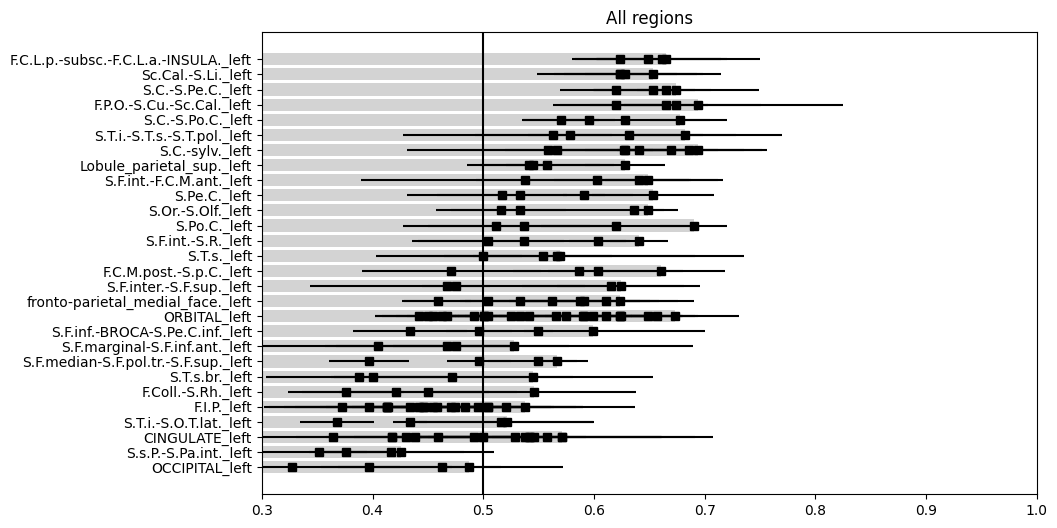

In [81]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

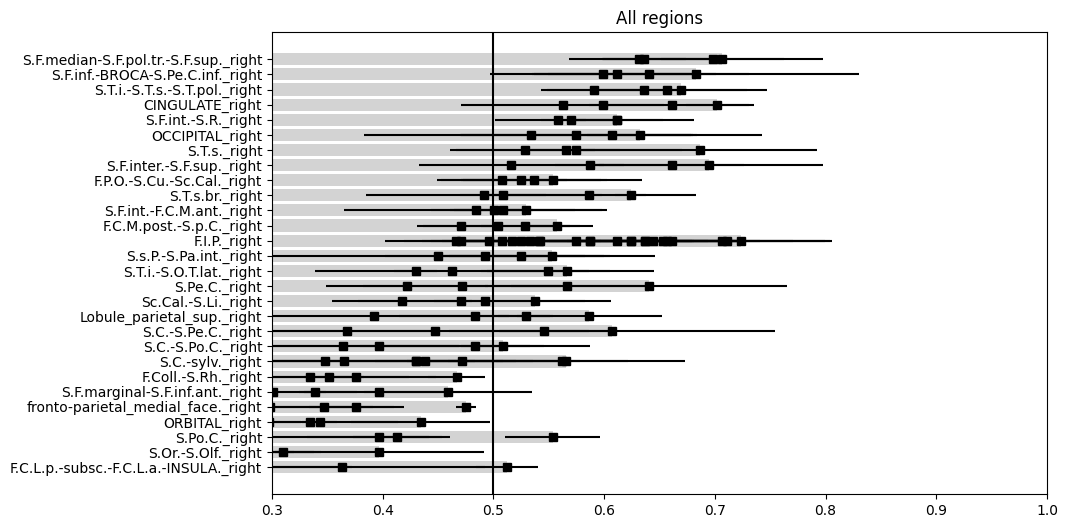

In [82]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [83]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.627469,0.108282,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.669187,0.042841,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.624126,0.057241,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.656996,0.015909,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.466975,0.025831,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
299,S.F.inter.-S.F.sup._right,0.516101,0.083620,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
300,S.T.s._left,0.500000,0.035281,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
301,F.C.M.post.-S.p.C._right,0.504527,0.073973,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
302,ORBITAL_right,0.297377,0.028928,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [84]:
df.to_csv(output_filename)